In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import itertools
from scipy import stats

%cd '../jmeter/'

/Users/quby/Github/What-A-Capacity-Test/jmeter


# Introduction

An experiment is a test in which changes are made to the input variables of a system or process with the aim of **observing and identifying the reasons of changes in the output**.

Some of contrallable input are identified to study the response:

- Apache HTTP Server CPU
- Apache HTTP Server RAM
- MariaDB Server CPU
- MariaDB Server RAM
- Workload

For each factor a minimun and maximum level will be evaluated:

| Level | 1 | 2 |
| :-: | :-: | :-: |
| **Apache CPU** | 0.125 vCPU | 0.5 vCPU |
| **MariaDB CPU** | 0.125 vCPU | 0.5 vCPU |
| **Apache RAM** | 256 MB | 1 GB |
| **MariaDB RAM** | 256 MB | 1 GB |
| **Workload** | Static | Dynamic |

The response to be evuluted is the **mean throughput** of system.

### Fraction Factor Design

A full factor design $2^5*5$ would require a total of 160 experiments, in order to reduce number of expirements a fractional factor design $2^{5-2}*5$ will be placed on with a total of 40 expirements. 

Using following association:

| Factor | Name |
| :-: | :-: |
| **Apache CPU** | A |
| **MariaDB CPU** | B |
| **Apache RAM** | C |
| **MariaDB RAM** | D|
| **Workload** | E |

#### Effect Counfouding

A decision needs to be taken about factor counfounding, in particular designer decided to confuse:

- A = CE
- B = DE

This choices were dicted by the possible relationship between workload and memory RAM of same component.

In [62]:
C = [-1, +1]
D = [-1 , +1]
E = [-1 , +1]

Table = []

for x in itertools.product(C, D, E):
  Table.append(x)

TableSign = pd.DataFrame(Table, columns=["C", "D", "E"])
TableSign["CD"] = TableSign["C"] * TableSign["D"]
TableSign["A"] = TableSign["C"] * TableSign["E"]
TableSign["B"] = TableSign["D"] * TableSign["E"]
TableSign["CDE"] = TableSign["C"] * TableSign["D"] * TableSign["E"]
TableSign

,C,D,E,CD,A,B,CDE
0,-1,-1,-1,1,1,1,-1
1,-1,-1,1,1,-1,-1,1
2,-1,1,-1,-1,1,-1,1
3,-1,1,1,-1,-1,1,-1
4,1,-1,-1,-1,-1,1,1
5,1,-1,1,-1,1,-1,-1
6,1,1,-1,1,-1,-1,-1
7,1,1,1,1,1,1,1


Algebra of confunding is usefull to obtain generator polynomial and find relationship of confusions.

$$
\begin{cases}
A = CE \\
B = DE \\
\end{cases} \implies AB= CD
$$

This relationship is usefull to find generator polynomial $I$:

$$ CD = AB$$

$$ CD \cdot D = AB \cdot D $$

$$ C = ABD $$

$$ C \cdot C = ABD \cdot C $$

$$ I = ABCD$$

Generator polynomial can be used to calculate all of confounded effects:

| Effect | Confounded 1 | Confounded 2 | Confounded 3 |
| :-: | :-: | :-: | :-: |
| **C** | AE | ABD | BCDE | 
| **D** | BE | ABC | ACDE |
| **E** | AC | BD | ABCDE |
| **CD** | AB | BCE | ADE |
| **CE** | A | BCE | ABDE |
| **DE** | B | ACD | ABCE |
| **CDE** | AD | AC | ABE |

The response to be evuluted is the **mean throughput** of system.

## Data Load & Manipulation

Data are collected using Apache JMeter in folder `jmeter`, each subfolder represents a different experiment. Each subfolder contains files with the results of different experiment.

The results are stored in a CSV file with the following columns:

| Column | Description |
| :-: | :-: |
| timeStamp | Timestamp for each request |
| elapsed | elapsed time for each request |
| label | type of request |
| grpThreads | identifier of requester |
| allThreads | number of active threads at the time |
| Latency | latency time of request|
| SampleCount | successful request ? |
| ErrorCount | unsuccessful request ? |

Some other columns are defined in order to provide more information about the experiment:

| Column | Description |
| :-: | :-: |
| Errors | Number of unsuccessful requests at the time |
| Success | Number of successful requests at the time |
| Throughput | Number of successful requests per second |

Futhermore `timeStamp` column needs to be reformated in a time window of 5 minutes.’

In [63]:
def load_experiment(folder):
  """
  Load experiment data from different csv and manipulate to order and add usefull info
  """
  # All experiment will be loaded in array with a pandas dataframe for each test
  data = []

  # Load all files from folder
  files = glob.glob('./' + folder + '/*.csv')
  
  for i, csv in enumerate(files):
    data.append(pd.read_csv(csv))
    
    # Data will be ordered by timeStamp
    data[i].sort_values("timeStamp", inplace=True)
    data[i].reset_index(inplace=True)

    # Recalculate timeStamp using first response as time base
    data[i]["timeStamp"] = (data[i]["timeStamp"] - data[i]["timeStamp"][0]) / 1000
    
    # Define new columns with number of success and errors at current row
    data[i]["Errors"] = data[i]["ErrorCount"].cumsum()
    data[i]["Success"] = data[i].index - data[i]["Errors"]

    # Define Throughput Column
    data[i]["Throughput"] =   data[i]["Success"]  / data[i]["timeStamp"]

  return data

## Visual Analysis

Visual analysis is performed as preliminary step to obtain usefull information and make hypothesis. As shown in sign table, experiments with even number are performed using static workload, instead of experiments with odd number using dynamic workload.

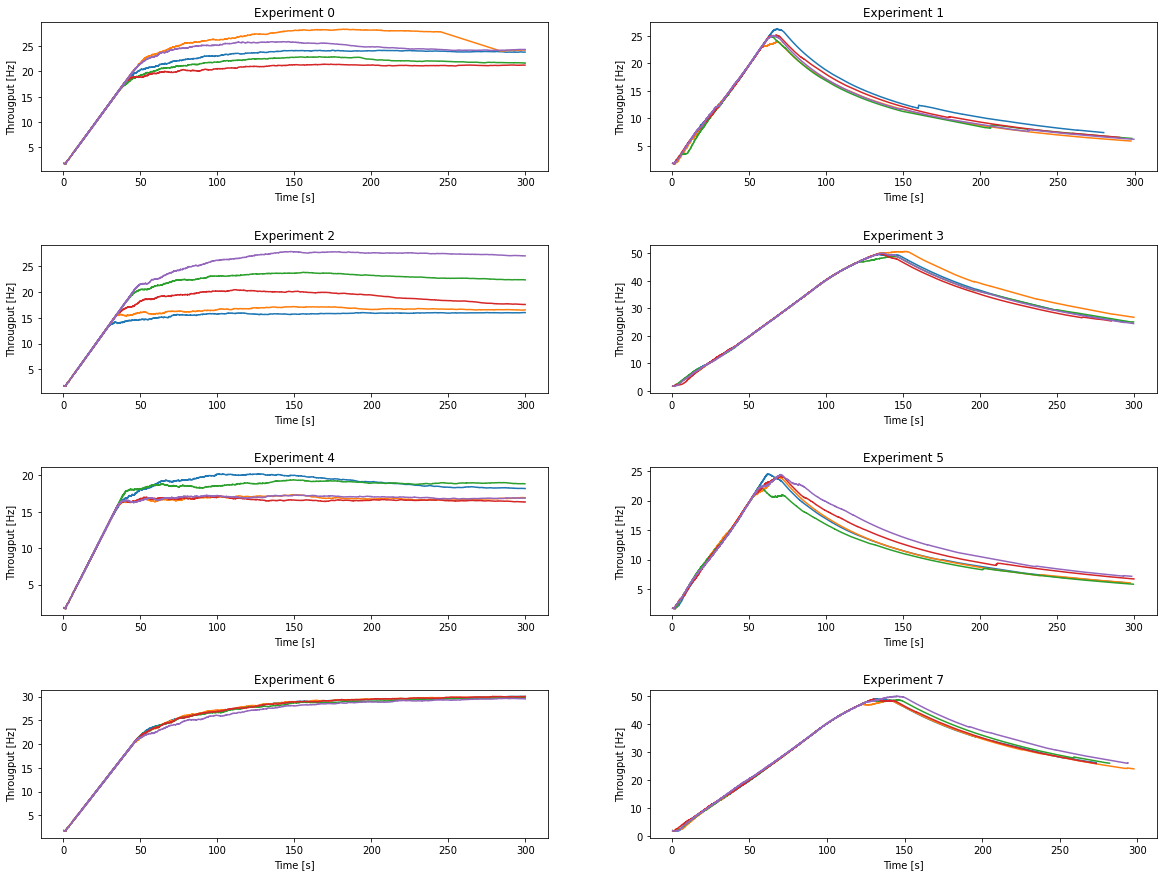

In [64]:
experiments = []

experiments.append(load_experiment("experiment_0"))
experiments.append(load_experiment("experiment_1"))
experiments.append(load_experiment("experiment_2"))
experiments.append(load_experiment("experiment_3"))
experiments.append(load_experiment("experiment_4"))
experiments.append(load_experiment("experiment_5"))
experiments.append(load_experiment("experiment_6"))
experiments.append(load_experiment("experiment_7"))

fig, axs = plt.subplots(4, 2, figsize=(20, 15))
fig.subplots_adjust(hspace=0.5)

for i in range(len(experiments)):
  axs[i // 2, i % 2].set_title(f"Experiment {i}")
  axs[i // 2, i % 2].set_xlabel("Time [s]")
  axs[i // 2, i % 2].set_ylabel("Througput [Hz]")
  for test in range(5):
    axs[i // 2, i % 2].plot(experiments[i][test]["timeStamp"], experiments[i][test]["Throughput"])
    


In static workload, after knee point the throughput is almost constant, while in dynamic workload the response decreases significantly due to MariaDB server's restart.

The response, evaluated in terms of mean throughput, will be significantly different for static workload and dynamic workload, so we will be expected to observe Workload factor as important effect.

Futhermore the knee and usable point distance in the throughput curve are different for static workload and dynamic workload, so we will be accurately choice the knee point in a different way for each workload.

# Response calculation and Modelling

In precedent section we have displayed the throughput of system compared to time in different system configurations, the response to be evuluted is the **mean throughput** of system.

In [65]:
response = []
for i in range(len(experiments)):
  for test in range(5):
    response.append(experiments[i][test]["Throughput"].mean())

Response is collected in an array that needs to be reshaped in order to be able to be used in statistical analysis.
 
Considering $2^{5-3}*5$ factorial design we need to reshape the 1-D array in a 4-D array, 3 dimension are used to define the different factor levels, and the last dimension is used to define repetition of experiment.

In [66]:
response_np = np.array(response)
response_np = np.reshape(response_np.T, (2, 2, 2, 5))
response_np

array([[[[22.45680413, 25.34245573, 20.99048817, 20.05275441,
          23.5784328 ],
         [14.7786543 , 16.39861813, 14.54329058, 13.77135256,
          14.26517158]],

        [[15.25990572, 16.10579056, 21.79984328, 18.47131803,
          25.38139086],
         [35.39548049, 36.51831185, 34.97458135, 34.60503357,
          35.07483442]]],


       [[[18.44639179, 16.3463311 , 18.20315445, 16.15665578,
          16.46270539],
         [13.35072376, 13.69763429, 13.50357047, 14.54896427,
          13.7762738 ]],

        [[26.97892935, 27.04897362, 26.77488977, 26.99325562,
          26.39210119],
         [34.94156118, 34.08895633, 35.26343678, 34.95569852,
          35.86364862]]]])

## Data Modelling

Once done response calculation, we need to model the response in order to obtain a statistical model.

$$y_{ijkz} = \mu + \alpha_i + \beta_j + \gamma_k + \delta_{ij} + \zeta_{ik} + \eta_{jk} + \sigma_{ijk} + e_{ijkz}$$

Where:

| Variable | Description |
| :-: | :-: |
| **$\mu$** | Mean of response |
| **$\alpha_i$** | Factor C effect |
| **$\beta_j$** | Factor D effect |
| **$\gamma_k$** | Factor E effect |
| **$\delta_{ij}$** | Interaction C-D effect |
| **$\zeta_{ik}$** | Interaction C-E effect |
| **$\eta_{jk}$** | Interaction D-E effect |
| **$\sigma_{ijk}$** | Interaction C-D-E effect |
| **$e_{ijkz}$** | Sperimental error |


Some rules to be followed:

- The effects are computed so that their sum is zero.

$$ \sum_{i=1}^m \alpha_i = 0 $$

$$ \sum_{j=1}^n \beta_j = 0 $$

$$ \sum_{k=1}^p \gamma_k = 0 $$

- The interaction are computed so that their sum in every dimension is zero.

$$ \sum_{i=1}^m \sum_{j=1}^n \delta_{ij} = 0 $$

$$ \sum_{i=1}^m \sum_{k=1}^p \zeta_{ik} = 0 $$

$$ \sum_{j=1}^n \sum_{k=1}^p \eta_{jk} = 0 $$

$$ \sum_{i=1}^m \sum_{j=1}^n \sum_{k=1}^p \sigma_{ijk} = 0 $$

- The errors in each expirement add up to zero.

$$ \sum_{z=1}^r e_{ijkz} = 0 \forall i,j,k $$

## Computation of effects

Means are used to compute the effects and the interaction, using following relations:

$$\overline{y_{i..}} = \frac{1}{jkr} \sum_{jkz}y_{ijkz} = \mu + \alpha_i$$

$$\overline{y_{j..}} = \frac{1}{ikr} \sum_{ikz}y_{ijkz} = \mu + \beta_j$$

$$\overline{y_{k..}} = \frac{1}{ijr} \sum_{ijz}y_{ijkz} = \mu + \gamma_k$$

$$\overline{y_{ij.}} = \frac{1}{kr} \sum_{kz}y_{ijkz} = \mu + \alpha_i + \beta_j + \delta_{ij}$$

$$\overline{y_{i.k}} = \frac{1}{jz} \sum_{jz}y_{ijkz} = \mu + \alpha_i + \gamma_j + \zeta_{ik}$$

$$\overline{y_{.jk}} = \frac{1}{iz} \sum_{iz}y_{ijkz} = \mu + \beta_j + \gamma_k + \eta_{jk}$$

$$\overline{y_{ijk}} = \frac{1}{z} \sum_{z}y_{ijkz} = \mu + \alpha_i + \beta_j + \gamma_k + \delta_{ij} + \zeta_{ik} + \eta_{jk} + \sigma_{ijk}$$

$$\overline{y_...} = \frac{1}{ijkz} \sum_{ijkz} y_{ijkz} = \mu

In [67]:
y = response_np.mean()
y_i = response_np.mean(axis=(1, 2, 3))
y_j = response_np.mean(axis=(0, 2, 3))
y_k = response_np.mean(axis=(0, 1, 3))
y_ij = response_np.mean(axis=(2, 3))
y_ik = response_np.mean(axis=(1, 3))
y_jk = response_np.mean(axis=(0, 3))
y_ijk = response_np.mean(axis=(3))

So effects and interactions can be computed using mean relationship, in the following way:

In [68]:
c_effect = y_i - y
d_effect = y_j - y
e_effect = y_k - y
cd_effect = y_ij - y - c_effect - d_effect
ce_effect = y_ik - y - c_effect - e_effect
de_effect = y_jk - y - d_effect - e_effect
cde_effect = y_ijk - y - c_effect - d_effect - e_effect - cd_effect - ce_effect - de_effect

Esperimental error is defined as difference between response and observed response:

$$e_{ijkz} = y_{ijkz} - \overline{y_{ijkz}}$$

In [69]:
residual = np.stack([response_np[..., i] - y_ijk for i in range(response_np.shape[-1])], axis=-1)
residual

array([[[[-2.73829172e-02,  2.85826868e+00, -1.49369888e+00,
          -2.43143264e+00,  1.09424575e+00],
         [ 2.72368712e-02,  1.64720070e+00, -2.08126848e-01,
          -9.80064871e-01, -4.86245850e-01]],

        [[-4.14374397e+00, -3.29785913e+00,  2.39619359e+00,
          -9.32331660e-01,  5.97774117e+00],
         [ 8.18321505e-02,  1.20466352e+00, -3.39066983e-01,
          -7.08614768e-01, -2.38813915e-01]]],


       [[[ 1.32334408e+00, -7.76716602e-01,  1.08010675e+00,
          -9.66391919e-01, -6.60342310e-01],
         [-4.24709556e-01, -7.77990260e-02, -2.71862848e-01,
           7.73530953e-01,  8.40477344e-04]],

        [[ 1.41299439e-01,  2.11343715e-01, -6.27401407e-02,
           1.55625709e-01, -4.45528722e-01],
         [-8.10991036e-02, -9.33703960e-01,  2.40776491e-01,
          -6.69617646e-02,  8.40988338e-01]]]])

# Allocation of Variance and ANOVA

In order to evaluate the effects of factors, we need to estimate the variance and significance of the effects. We will use the following procedure:

1. Calculate variance for each factor and interaction.
2. Individue the most important factors/interactions.
3. Validating the results by conducting an ANOVA on interearated factors.

Variance is calculated using Sum of Squares method, remembering that sum of effect, interaction and error along axis are all equal to zero, so relationship can be simplified to:

$$
\sum y^2_{ijkz} = mnpr\cdot μ^2 + npr\sum_{i}α^2 + mpr\sum_{j}β^2 + mnr\sum_{k}γ^2 + pr\sum_{i,j}δ^2 + mr\sum_{i,k}ζ^2 + nr\sum_{j,k}\eta^2 + r \sum_{i,j,k}\theta^2 + \sum_{i,j,k,z} e^2 
$$

$$
SSY = SSO + SSC + SSD + SSE + SSCD + SSCE + SSDE + SSCDE
$$

$SSY$ rappresents Sum of Square of model response, however variance must be calculate in relationship with Sum of Square of Total Variation $SST$, defined as difference between model response e mean response.

$$SST = \sum_{i,j,k,z} (y_{ijkz}-\overline{y_{....}})^2$$

$$
SST = SSY - SSO = SSC + SSD + SSE + SSCD + SSCE + SSDE + SSCDE
$$

In [70]:
m = 2
n = 2
p = 2
r = 5

SSO = m*n*p*r * y**2
SSC = n*p*r * (c_effect ** 2).sum()
SSD = m*p*r * (d_effect ** 2).sum()
SSE = m*n*r * (e_effect ** 2).sum()
SSCD = p*r * (cd_effect ** 2).sum()
SSCE = m*r * (ce_effect ** 2).sum()
SSDE = n*r * (de_effect ** 2).sum()
SSCDE = r * (cde_effect ** 2).sum()
SSERROR = (residual ** 2).sum()
SSERROR
SST = SSC + SSD + SSE + SSCD + SSCE + SSDE + SSCDE + SSERROR

## Allocation of Variation

Allocation of Variation of factor/interaction is calculated as follows:

$$Variation = \frac{\text{Sum of Square of factor}}{SST}$$

Recording confounded effects:

- A = CE
- B = DE

A bar chart is used to indicate the most important factor/interaction:

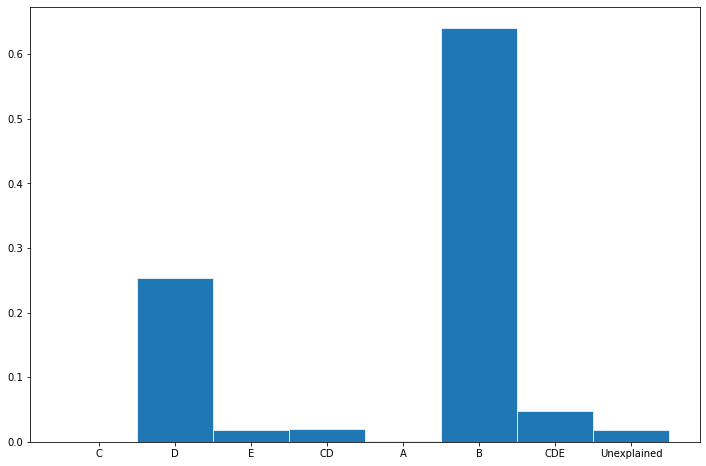

In [71]:
legend = [ "C", "D", "E", "CD", "A", "B", "CDE", "Unexplained"]
Variance = [ SSC/SST, SSD/SST, SSE/SST, SSCD/SST, SSCE/SST, SSDE/SST, SSCDE/SST, SSERROR/SST]

# plot
fig, ax = plt.subplots(figsize=(12,8))

ax.bar(legend, Variance,  width=1, edgecolor="white", linewidth=0.7)

plt.show()

The most important factor/interaction are:

- D : MariaDB RAM
- B : MariaDB CPU

As shown dynamic workload are calculated as more important than static workload, so the most important factors are MariaDB resources. A futher investigation is needed to evaluate the static workload.

## ANOVA test

In order to validate the results, we need to conduct an ANOVA test on important factors, so prelimanary we compute degrees of freedom of each factor:

$$
SST = SSY - SSO= SSC + SSD + SSE + SSCD + SSCE + SSDE + SSCDE
$$

$$
mnpr - 1 = (m-1) + (n-1) + (p-1) + (m-1)(n-1) + (m-1)(p-1) + (n-1)(p-1) + (m-1)(n-1)(p-1) + mnp(r-1)
$$

Using a 2^k factorial design, we have only one degree of freedom for each factor and interaction, so we have only one Fisher table's value to compare (remembering that degree of error $mnp(r-1) = 32$).

Using a significance level of 0.05, we can calculate F-value to compare to significance of factor/interaction, this value is 4.15.

Significance of level using ANOVA classical test is calculated as follows:

$$F = \frac{\frac{SSA}{\nu_A}}{\frac{SSE}{\nu_e}} = \frac{MSA}{MSE}$$

Where:

- $\nu_A$ : degree of freedom for factor A
- $\nu_e$ : degree of freedom for sperimental error
- $MSA$ : mean square of factor A
- $MSE$ : mean square of sperimental error

In [72]:
MSD = SSD
MSB = SSDE
MSE = SSERROR/(r-1)

print(f"F_D: {MSD/MSE}")
print(f"F_B: {MSB/MSE}")

F_D: 57.70154148075994
F_B: 145.8255725811412


Both factors are significant, so the results are significant, and factor has a low importance biased from static workload, in which importance is almost zero.

A different investigation using 2 different experiments for each workload is needed to validate the results.

In [73]:
print(f"Importance Apache RAM: {Variance[1]*100} %")
print(f"Importance Apache CPU: {Variance[5]*100} %")

Importance Apache RAM: 25.364887930582526 %
Importance Apache CPU: 64.10312811429868 %
